In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

train_size = 1561
test_size = 424
image_length = 256

X_train = np.load("train_data.npy")
y_train = np.load("train_labels.npy")

X_test = np.load("test_data.npy")
y_test = np.load("test_labels.npy")


def extract_features(X, data_size):
    X_ext = np.zeros(shape=(data_size, 3))
    
    # setting the X[:, 0] = 1 in order to absorb the bias term w[0]
    X_ext[:, 0] = 1
    
    # extracting intensity (amount of black pixels)
    for i in range(data_size):
        black_pixels = 0
        for j in range(image_length):
            if X[i][j] > 0:
                black_pixels += 1
        
        X_ext[i][1] = black_pixels
    
    # extracting symmetry (negative of absolute difference between an image and its flipped versions)
    for i in range(data_size):
        asymmetry = 0
        for row in range(16):
            for col in range(8):
                asymmetry += abs(X[i][16*row+col] - X[i][16*row+15-col])
                
        X_ext[i][2] = -asymmetry
        
    
    return X_ext


In [2]:
X_train_ext = extract_features(X_train, train_size)
X_test_ext = extract_features(X_test, test_size)

In [3]:
def plot_features(X, y, data_size):
    for i in range(data_size):
        # digit 1
        if y[i] == 1:
            plt.scatter(X[i][1], X[i][2], color = 'b', marker = 'o')
            
        # digit 5
        elif y[i] == -1:
            plt.scatter(X[i][1], X[i][2], color = 'r', marker = 'x')
        
    plt.xlabel("intensity")
    plt.ylabel("symmetry")
            

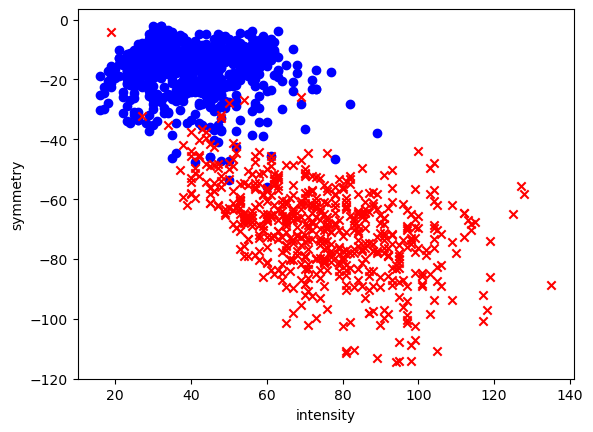

In [4]:
# plotting features of the extracted train data
# o: digit 1
# x: digit 5
plot_features(X_train_ext, y_train, train_size)

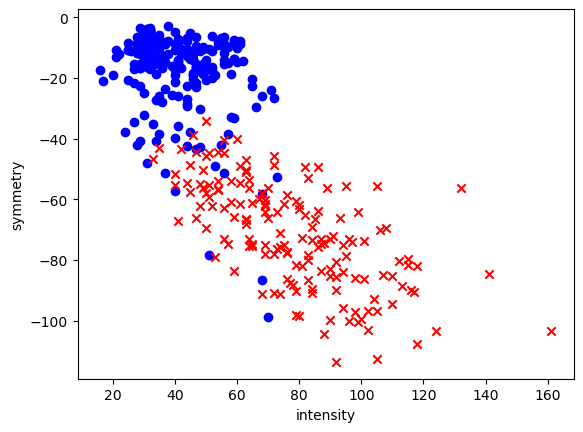

In [5]:
# plotting features of the extracted test data
# o: digit 1
# x: digit 5
plot_features(X_test_ext, y_test, test_size)

In [7]:
def sigmoid(y, w, x):
    ''' Calculates sigmoid function for given parameters
    
    Parameters
    ----------
    y: float
        true label
    w: array, shape [D]
        Logistic regression coefficients
    x: array, shape [D]
        input features
        
    Returns
    -------
    s: float
        Result of the sigmoid function given above parameters
        
    '''
    a = y * np.dot(w, x)
    s = 1 / (1 + math.exp(-a))
    return s


def gradient(y, w, X, data_size):
    gradient = 0
    for i in range(data_size):
        gradient -= y[i] * X[i] * sigmoid(-y[i], w, X[i])
        
    gradient /= data_size
    return gradient


def logistic_regression(y, X, data_size, feature_no, learning_rate, iterations):
    # w[0] is the bias term
    w = np.zeros(feature_no+1)
    
    for i in range(iterations):
        g = gradient(y, w, X, data_size)
        w = w - learning_rate * g
        
    return w


In [18]:
# applying logistic regression to find coefficients that will approximately minimize the error
w_ext = logistic_regression(y_train, X_train_ext, train_size, 2, 0.1, 5000)

print(w_ext)

[22.8462141  -0.0926886   0.40482195]


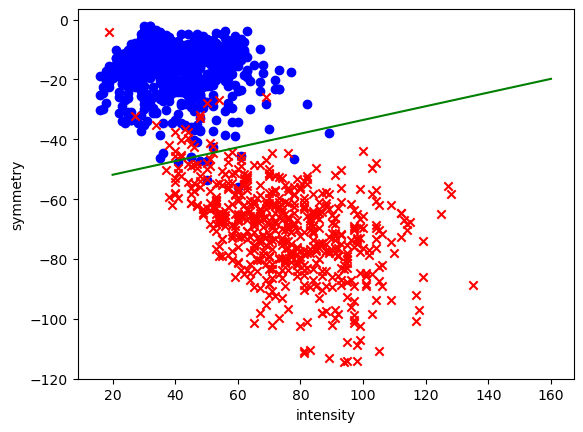

In [19]:
g = lambda x : -w_ext[1]*x/w_ext[2] - w_ext[0]/w_ext[2]
x_axis, y_axis = [20, 160], [g(20), g(160)]

# plotting features of the extracted train data with the separator
plot_features(X_train_ext, y_train, train_size)
plt.plot(x_axis, y_axis, color = 'green')
plt.show()

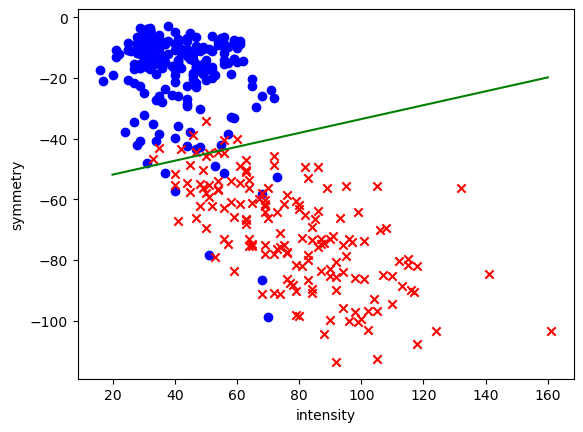

In [20]:
# plotting features of the extracted test data with the separator
plot_features(X_test_ext, y_test, test_size)
plt.plot(x_axis, y_axis, color = 'green')
plt.show()

In [11]:
def calculate_error(y, w, X, data_size):
    error = 0
    for i in range(data_size):
        s = y[i] * np.dot(w, X[i]) 
        error += np.log(1 + math.exp(-s))
    
    error /= data_size
    return error

def calculate_accuracy(y, w, X, data_size):
    correct = 0
    for i in range(data_size):
        if y[i] * np.dot(w, X[i]) > 0:
            correct += 1
    
    return 100 * correct / data_size
            
    

print(f"Train error is {calculate_error(y_train, w_ext, X_train_ext, train_size)}")
print(f"Test error is {calculate_error(y_test, w_ext, X_test_ext, test_size)}")

print(f"Train accuracy is % {calculate_accuracy(y_train, w_ext, X_train_ext, train_size)}")
print(f"Test accuracy is % {calculate_accuracy(y_test, w_ext, X_test_ext, test_size)}")
    

Train error is 0.07783669203816104
Test error is 0.2379474377060314
Train accuracy is % 98.0140935297886
Test accuracy is % 95.75471698113208


In [21]:
def gradient_with_regularization(y, w, X, data_size, lmd):
    return gradient(y, w, X, data_size) + 2*lmd*w

def calculate_error_with_regularization(y, w, X, data_size, lmd):
    return calculate_error(y, w, X, data_size) + lmd*np.dot(w, w)

def logistic_regression_with_regularization(y, X, data_size, feature_no, learning_rate, iterations, lmd):
    # +1 for the bias term in w
    w = np.zeros(feature_no+1)
    
    for i in range(iterations):
        g = gradient_with_regularization(y, w, X, data_size, lmd)
        w = w - learning_rate * g
        
    return w


In [23]:
def cross_validation(y, X, data_size, feature_no, learning_rate, iterations, lambdas):
    #np.random.seed(1)
    #np.random.shuffle(X)

    # K-fold
    K = 10
    block_size = data_size // K
    
    errors = np.zeros(lambdas.shape)

    for idx, lmd in enumerate(lambdas):
        for i in range(K):
            X_in = np.r_[X[:i*block_size], X[(i+1)*block_size:]]
            y_in = np.r_[y[:i*block_size], y[(i+1)*block_size:]]
            X_val = X[i*block_size:(i+1)*block_size]
            y_val = y[i*block_size:(i+1)*block_size]

            w_in = logistic_regression_with_regularization(
                y_in, X_in, data_size - block_size, image_length, learning_rate, iterations, lmd)
            errors[idx] += calculate_error_with_regularization(y_val, w_in, X_val, block_size, lmd)

        errors[idx] /= K

    return errors
    


In [27]:
# adding constant term 1 for the bias in w
X_train_flat = np.c_[np.ones(train_size), X_train]
X_test_flat = np.c_[np.ones(test_size), X_test]

lambdas = np.array([0.1*i for i in range(1,11)])

errors = cross_validation(y_train, X_train_flat, train_size, image_length, 0.05, 50, lambdas)

print(errors)

[0.05410255 0.06198197 0.06941511 0.07644486 0.08310926 0.08944211
 0.09547341 0.10122981 0.10673502 0.11201016]


In [42]:
w = logistic_regression(y_train, X_train_flat, train_size, image_length, 0.1, 1000)
print(f"Train error is {calculate_error(y_train, w, X_train_flat, train_size)}")
print(f"Test error is {calculate_error(y_test, w, X_test_flat, test_size)}")

print(f"Train accuracy is % {calculate_accuracy(y_train, w, X_train_flat, train_size)}")
print(f"Test accuracy is % {calculate_accuracy(y_test, w, X_test_flat, test_size)}")


Train error is 0.002466841808840482
Test error is 0.07214301904912819
Train accuracy is % 100.0
Test accuracy is % 99.05660377358491


In [43]:
w_r = logistic_regression_with_regularization(y_train, X_train_flat, train_size, image_length, 0.1, 1000, 0.1)
print(f"Train error is {calculate_error_with_regularization(y_train, w_r, X_train_flat, train_size, 0.1)}")
print(f"Test error is {calculate_error_with_regularization(y_test, w_r, X_test_flat, test_size, 0.1)}")

print(f"Train accuracy is % {calculate_accuracy(y_train, w_r, X_train_flat, train_size)}")
print(f"Test accuracy is % {calculate_accuracy(y_test, w_r, X_test_flat, test_size)}")


Train error is 0.10042826534380903
Test error is 0.12996226240482286
Train accuracy is % 99.74375400384369
Test accuracy is % 98.34905660377359
